In [1]:
from importlib import reload
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers

In [51]:
# import modules
import src.models
reload(src.models)
from src.models import *

import src.dataMethods
reload(src.dataMethods)
from src.dataMethods import *

import src.features as features
reload(features)

<module 'src.features' from 'C:\\Users\\Andrew\\Documents\\CeR\\GestRec\\leap_gesture_rec\\src\\features.py'>

In [3]:
gestures, g2idx, idx2g = get_gestures(version=1)

In [ ]:
b = 'recordings/derived_test.csv'
df = CSV2VoI(b)
print(df[['left_index_tipPosition_0', 'left_index_tipPosition_1', 'left_pinchDistance']])
print(df[['right_index_tipPosition_0', 'right_index_tipPosition_1', 'right_pinchDistance']])
df = mirror_data(df)
print(df[['right_index_tipPosition_0', 'right_index_tipPosition_1', 'right_pinchDistance']])
print(df[['left_index_tipPosition_0', 'left_index_tipPosition_1', 'left_pinchDistance']])

In [76]:
mirror_train = 'data/mirror/mirror_train.csv'
mirror_val = 'data/mirror/mirror_test.csv'
mirror_train2 = 'data/mirror/mirror_train3.csv'
mirror_val2 = 'data/mirror/mirror_test3.csv'
shape_train = 'data/loopsV0/shapes2loops.csv'
shape_test = 'data/loopsV0/shapes_test.csv'
n_frames = 40
X, y = CSV2examples(raw_file=mirror_train2, g2idx=g2idx, n_frames=n_frames, target_fps=30, standardize=True, dicts_gen=True, mirror=False, derive_features=True)
X2, y2 = CSV2examples(raw_file=mirror_train, g2idx=g2idx, n_frames=n_frames, target_fps=30, standardize=True, dicts_gen=False, mirror=False)
X = np.concatenate([X,X2])
y = np.concatenate([y, y2])
X_val, y_val = CSV2examples(raw_file=mirror_val2, g2idx=g2idx, n_frames=n_frames, target_fps=30, standardize=True, mirror=False, derive_features=True)
print(X.shape)

mean fps: 28.79
target fps: 30
taking every 1 frames
99.83% of rows contain valid LH data
100.00% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True


C:\Users\Andrew\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Andrew\Documents\CeR\GestRec\leap_gesture_rec\src\dataMethods.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.dropna(inplace=True)


dealt with 0 of 4754 rows with nans
Index(['f1_f1', 'f2_f2', 'f3_f3', 'f4_f4', 'f5_f5', 'left_f1_2', 'left_f1_p',
       'left_f1_p_plain', 'left_f2_3', 'left_f2_p', 'left_f2_p_plain',
       'left_f3_4', 'left_f3_p', 'left_f3_p_plain', 'left_f4_5', 'left_f4_p',
       'left_f4_p_plain', 'left_f5_p', 'left_f5_p_plain', 'left_grabAngle',
       'left_palmPosition_0', 'left_palmPosition_1', 'left_palmPosition_2',
       'left_pinchDistance', 'palm_distance', 'right_f1_2', 'right_f1_p',
       'right_f1_p_plain', 'right_f2_3', 'right_f2_p', 'right_f2_p_plain',
       'right_f3_4', 'right_f3_p', 'right_f3_p_plain', 'right_f4_5',
       'right_f4_p', 'right_f4_p_plain', 'right_f5_p', 'right_f5_p_plain',
       'right_grabAngle', 'right_palmPosition_0', 'right_palmPosition_1',
       'right_palmPosition_2', 'right_pinchDistance'],
      dtype='object')
mean fps: 28.79
target fps: 30
taking every 1 frames
99.71% of rows contain valid LH data
100.00% of rows contain valid RH data
Found left ha

In [ ]:
X, y = folder2examples('data/train/', target_fps=25, g2idx=g2idx)

In [77]:
model = many2one_model(n_features = X.shape[-1], n_frames=X.shape[1], n_gestures=len(g2idx), n_layers=1, rnn_units=5, recurrent_dropout=0.2, bidirectional=False)

Model: "many2one"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 40, 44)]          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 5)                 1000      
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 48        
Total params: 1,048
Trainable params: 1,048
Non-trainable params: 0
_________________________________________________________________


In [78]:
# note: using hs 30, recurrent dropout 0.5, bidirectional, and not including features added on the 3/02 or getting rid of VoI_drop features, got high 80s percentage accuracy on val
# maybe it was 25fps?
# with the new features, can get 89% val accuracy with 35 frame long examples. 25 is too short.
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, validation_data=(X_val, y_val), epochs=80, batch_size = 50)

Train on 525 samples, validate on 104 samples
Epoch 1/80
525/525 [==============================] - 2s 3ms/sample - loss: 2.0809 - accuracy: 0.1295 - val_loss: 2.0972 - val_accuracy: 0.0865
Epoch 2/80
525/525 [==============================] - 0s 359us/sample - loss: 2.0091 - accuracy: 0.1619 - val_loss: 2.0376 - val_accuracy: 0.0865
Epoch 3/80
525/525 [==============================] - 0s 331us/sample - loss: 1.9515 - accuracy: 0.2305 - val_loss: 1.9871 - val_accuracy: 0.1154
Epoch 4/80
525/525 [==============================] - 0s 323us/sample - loss: 1.9040 - accuracy: 0.2667 - val_loss: 1.9440 - val_accuracy: 0.1346
Epoch 5/80
525/525 [==============================] - 0s 342us/sample - loss: 1.8579 - accuracy: 0.3086 - val_loss: 1.9054 - val_accuracy: 0.2019
Epoch 6/80
525/525 [==============================] - 0s 359us/sample - loss: 1.8213 - accuracy: 0.3371 - val_loss: 1.8705 - val_accuracy: 0.2500
Epoch 7/80
525/525 [==============================] - 0s 350us/sample - loss: 1.

In [81]:
model.save('models/V1/40f_5hs_RH.h5')

In [39]:
model = tf.keras.models.load_model('models/V2/25f_32hs_15c_2.h5')

In [41]:
# load test data
X_test, y_test = CSV2examples('data/recordings/test_loop.csv', g2idx=g2idx, n_frames=50)

mean fps: 115.19
target fps: 25
skipping every 5 frames
Found left hand data:  False
Found right hand data:  True
dropped 0 of 2777 rows with nans


In [50]:
# predict on a random test case
i = np.random.randint(0, len(X_test))
print(i)
pred = model.predict(np.expand_dims(np.array(X_test[i]), axis=0))
print(pred)
print('Predicted: ', idx2g[np.argmax(pred)])
print('Truth: ', idx2g[y_test[i]])

33
[[0.95594496 0.04405507]]
Predicted:  no_gesture
Truth:  fist


In [54]:
print(idx2g[y[1]])

so_so


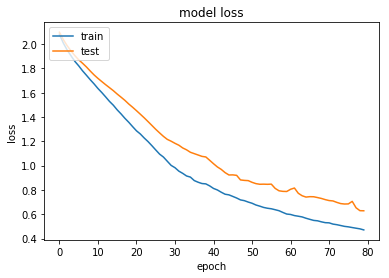

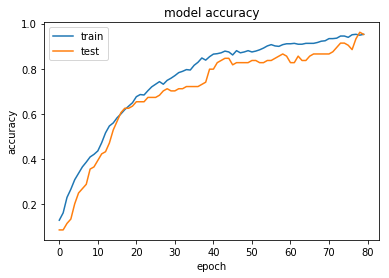

In [79]:
# plot history:
plt_metric(history, 'loss')
plt_metric(history, 'accuracy')

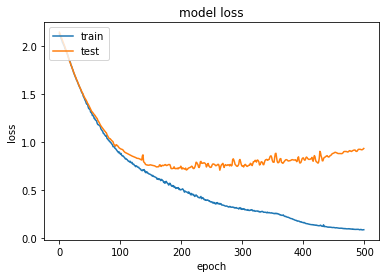

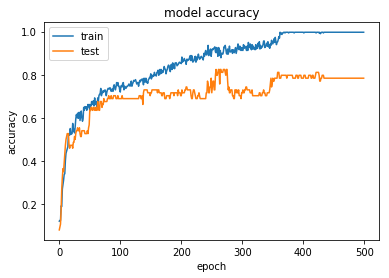

In [51]:
# plot history:
plt_metric(history, 'loss')
plt_metric(history, 'accuracy')

In [41]:
test2i = 'recordings/test2i.csv'
X_val, y_val = CSV2examples(raw_file=test2i, g2idx=g2idx, n_frames=n_frames, target_fps=30, standardize=True, mirror=False)

mean fps: 28.80
target fps: 30
taking every 1 frames
99.53% of rows contain valid LH data
100.00% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
dealt with 0 of 2344 rows with nans


In [80]:
# get confusion matrix
pred = np.argmax(model.predict(X_val), axis=-1)
pred_gest = [idx2g[i] for i in pred]
y_gest = [idx2g[i] for i in y_val]
pd.crosstab([y_gest], [pred_gest], rownames=['Actual'], colnames=['Predicted'])

Predicted,fist,gun,maybe,no_gesture,open_close,pointing,shuffle_over,so_so
Actual,,,,,,,,
fist,10,0,0,0,3,0,0,0
gun,0,12,0,0,0,0,1,0
maybe,0,0,13,0,0,0,0,0
no_gesture,0,0,0,13,0,0,0,0
open_close,1,0,0,0,12,0,0,0
pointing,0,0,0,0,0,13,0,0
shuffle_over,0,0,0,0,0,0,13,0
so_so,0,0,0,0,0,0,0,13


In [100]:
Xa = [[[0,1],[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8],[1,1],[1,2],[1,3],[1,4],[1,5],[3,1],[3,2],[3,3],[3,4],[3,5],[3,6],[3,7],[4,1],[4,2]]]
ya = [0,0,0,0,0,0,0,0,1,1,1,1,1,3,3,3,3,3,3,3,4,4]
xb, yb = X_y2examples(Xa, ya, n_frames=4)
print(xb)
print(yb)

[[[0 1]
  [0 2]
  [0 3]
  [0 4]]

 [[0 3]
  [0 4]
  [0 5]
  [0 6]]

 [[0 5]
  [0 6]
  [0 7]
  [0 8]]

 [[1 1]
  [1 2]
  [1 3]
  [1 4]]

 [[3 1]
  [3 2]
  [3 3]
  [3 4]]

 [[3 3]
  [3 4]
  [3 5]
  [3 6]]]
[0 0 0 1 3 3]


In [94]:
Xa[0:2]

[[0, 1], [0, 2]]